# 06: Introduction to Cross-Validation with Scikit-Learn

### 🎯 Objective
This notebook introduces the concept of **Data Splitting**, a fundamental practice in machine learning to prevent overfitting. We will use the `scikit-learn` library to easily split our data into **Training** and **Test** sets.

### 📚 Key Concepts
- **Overfitting:** When a model memorizes the training data but fails on new data.
- **Generalization:** The ability of a model to perform well on unseen data.
- **Train/Test Split:** Dividing your dataset into two parts: one for learning, one for evaluating.
- **`train_test_split`:** A utility function from `sklearn.model_selection` that automates this splitting.
- **Experimentation:** Testing how the *size* of the training set affects model performance.

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# NEW! The star of this show:
from sklearn.model_selection import train_test_split

## 1. Import and Process Data (Iris Dataset)
We use the same Iris dataset as before. We convert the pandas dataframe into PyTorch tensors.

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## 2. Understanding `train_test_split`

Before applying it to the real data, let's visualize how `train_test_split` works on a small, fake dataset.

We'll create a dummy matrix and show how the function randomly shuffles and splits it.

In [3]:
# create our fake dataset
# A matrix of numbers
fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T

# Fake labels (boolean True/False)
fakelabels = np.arange(10)>4

print('Original Data:')
print(fakedata)
print('Original Labels:')
print(fakelabels)

Original Data:
[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
Original Labels:
[False False False False False  True  True  True  True  True]


In [4]:
# use scikitlearn to split the data
# train_test_split takes arrays/tensors and returns 4 split arrays:
# 1. X_train (Training Features)
# 2. X_test  (Test Features)
# 3. y_train (Training Labels)
# 4. y_test  (Test Labels)

train_data,test_data, train_labels,test_labels = \
                        train_test_split(fakedata, fakelabels, test_size=.2)

# NOTE: test_size=.2 means 20% of data goes to Test set, 80% to Training set.

# print out the sizes
print('Training data size: ' + str(train_data.shape))
print('Test data size: ' + str(test_data.shape))
print(' ')

# print out the train/test data to see the shuffling
print('Training data: ')
print(train_data)
print(' ')

print('Test data: ')
print(test_data)

# Notice that the rows are SHUFFLED randomly, not just sliced.

Training data size: (8, 4)
Test data size: (2, 4)
 
Training data: 
[[ 61  62  63  64]
 [ 91  92  93  94]
 [ 81  82  83  84]
 [101 102 103 104]
 [ 11  12  13  14]
 [ 51  52  53  54]
 [ 21  22  23  24]
 [ 41  42  43  44]]
 
Test data: 
[[31 32 33 34]
 [71 72 73 74]]


## 3. Create the Model Function

Standard function to create a fresh instance of our Iris ANN.

In [5]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units (3 classes)
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer

## 4. Create the Training Function (with Splitting)

This function is where the magic happens. Instead of training on `data` and `labels` directly, we:
1.  Accept a `trainProp` argument (e.g., 0.8 for 80% training data).
2.  Use `train_test_split` inside the loop (or before) to create `X_train` and `X_test`.
3.  **Train ONLY on `X_train`.**
4.  **Evaluate on BOTH `X_train` and `X_test`** to see the difference.

In [6]:
# train the model

# global parameter
numepochs = 200

def trainTheModel(trainProp):

  # initialize losses and accuracy lists
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []
  
   # --- 1. Split Data ---
   # Here, trainProp is the proportion (e.g., 0.8)
  X_train,X_test, y_train,y_test = train_test_split(data,labels, train_size=trainProp)

  # loop over epochs
  for epochi in range(numepochs):

    # --- 2. Forward Pass & Train (On TRAIN data only) ---
    yHat = ANNiris(X_train)
    loss = lossfun(yHat,y_train)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # --- 3. Compute Accuracy ---

    # A) Training Accuracy (How well did it learn what it saw?)
    # compare prediction indices to true labels
    trainAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y_train).float()).item() )

    # B) Test Accuracy (How well does it generalize?)
    # Pass TEST data through model (no backprop here!)
    predlabels = torch.argmax( ANNiris(X_test),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y_test).float()).item() )

  # function output
  return trainAcc,testAcc


## 5. Test Run (Single Split)

Let's run it once with 80% training data. 

Observe the plot:
- **Red Line (Train):** Should go around 95%.
- **Blue Line (Test):** Should also be high, but might be slightly lower or noisier than the training accuracy.

In [7]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
# NOTE: the input is the training proportion (0.8 = 80%)
trainAcc,testAcc = trainTheModel(.8)


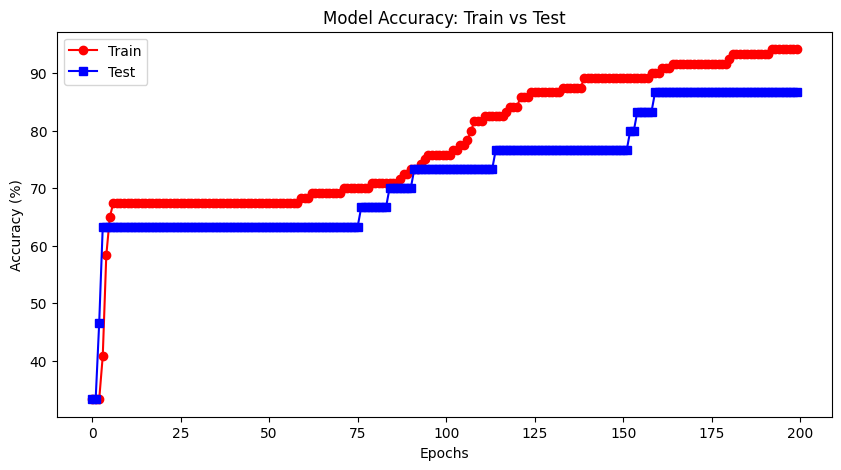

In [8]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Model Accuracy: Train vs Test')
plt.show()

## 6. The Experiment: Varying Training Set Size

Does having more data really help? Let's find out.

We will loop through different "Training Set Proportions" from 20% (`0.2`) to 95% (`0.95`).
- **Expectation:** With very little training data (e.g., 20%), the Test Accuracy should be low because the model hasn't seen enough examples to generalize.

In [9]:
trainSetSizes = np.linspace(.2,.95,10)

allTrainAcc = np.zeros((len(trainSetSizes),numepochs))
allTestAcc = np.zeros((len(trainSetSizes),numepochs))

for i in range(len(trainSetSizes)):

  # create a model
  ANNiris,lossfun,optimizer = createANewModel()

  # train the model
  trainAcc,testAcc = trainTheModel(trainSetSizes[i])

  # store the results
  allTrainAcc[i,:] = trainAcc
  allTestAcc[i,:] = testAcc

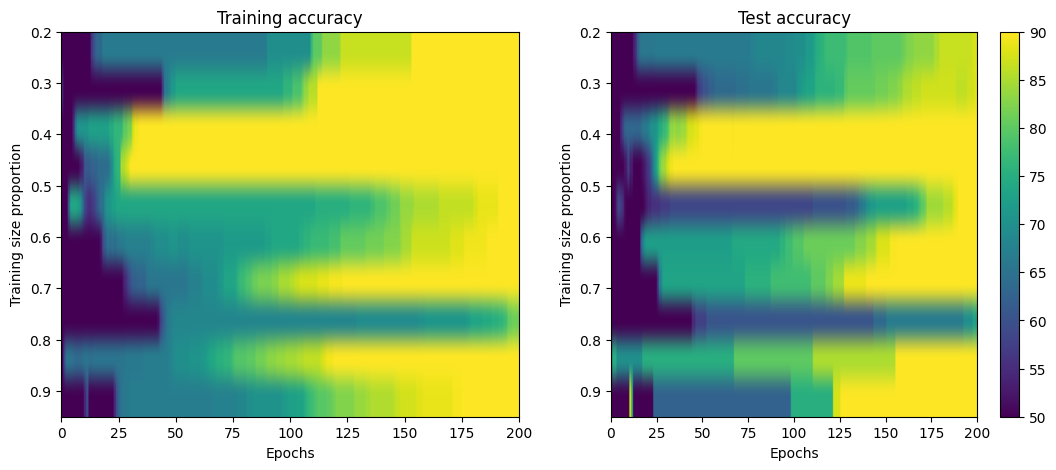

In [10]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

ax[0].imshow(allTrainAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

p = ax[1].imshow(allTestAcc,aspect='auto',
             vmin=50,vmax=90, extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')
fig.colorbar(p,ax=ax[1])

plt.show()